In [212]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from math import sqrt

In [213]:
# Load the MNIST dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Reshape the dataset
x_train = X_train.reshape(-1, 28 * 28)
x_test = X_test.reshape(-1, 28 * 28)
y_train = Y_train
y_test = Y_test

---

# Utils

In [214]:
def plot_digits(X, n_samples):
    """
    Afficher les données digits en paramètre
    """
    h_w = int(sqrt(n_samples))
    fig, axs = plt.subplots(h_w, h_w, figsize=(h_w, h_w))
    for digit in range(h_w):
        for column in range(h_w):
            ax = axs[digit, column]
            ax.imshow(X[digit * h_w + column], cmap='gray')
            ax.axis('off')

In [215]:
def plot_digits_with_Y(X, Y):
    """
    Afficher les 10 premiers chiffres de chaque chiffre
    """
    fig, axs = plt.subplots(10, 10, figsize=(5, 5))
    for digit in range(10):
        digit_indices = np.where(Y == digit)[0][:10]  # Sélectionner les indices des 10 premiers échantillons du chiffre
        for i, idx in enumerate(digit_indices):
            ax = axs[digit, i]
            ax.imshow(X[idx], cmap='gray')
            ax.axis('off')

In [216]:
def plot_pca_in_2d(projected_data: np.array, y: np.array):
    """
    Afficher le graphe des points de données après PCA
    """

    # Afficher le graphe des points de données après PCA
    plt.figure(figsize=(8, 6))
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=y, cmap='viridis')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Data points after PCA")
    plt.colorbar()

---

# PCA - Implementation

In [217]:
def custom_pca(
        X: np.array,
        n_compononents: int = 2,
        per_column: bool =False
):
    """
    Implémentation de l'algorithme PCA

    :return:
        Principal components et explained variance ratio
    """

    # 1. Standardization
    if per_column:
        X_standardized = (X - np.mean(X, axis=0)) / np.std(X, axis=0) # Per column
    else:
        X_standardized = (X - np.mean(X)) / np.std(X) # Whole dataset

    # 2. Covariance matrix
    # L'argument rowvar spécifie si les variables (ou caractéristiques)
    # sont disposées par ligne ou par colonne dans la matrice de données
    cov_matrix = np.cov(X_standardized, rowvar=False)

    # 3. Calculer les valeurs propres et les vecteurs propres
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # 3. Trier les valeurs propres dans l'ordre décroissant
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # 4. Sélectionner n composantes principales
    principal_components = sorted_eigenvectors[:, :n_compononents]

    # Bonus. Calculer la representativité de chaque composante
    total_variance = np.sum(sorted_eigenvalues)
    explained_variance_ratio = sorted_eigenvalues / total_variance

    return principal_components, explained_variance_ratio

---

# PCA - Reduction de dimensions

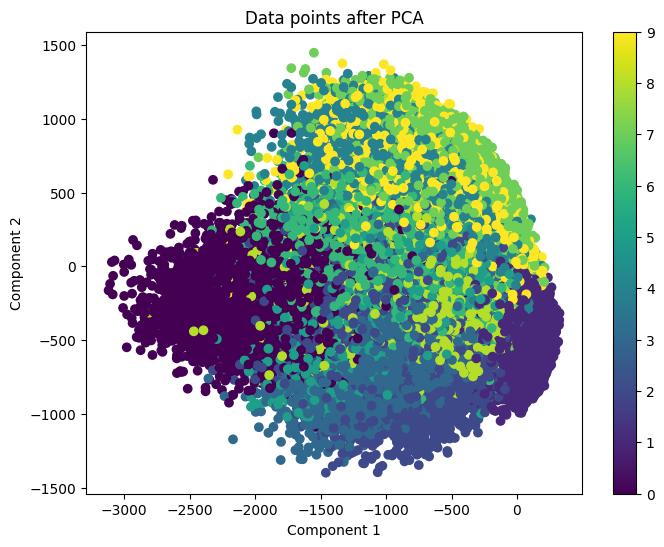

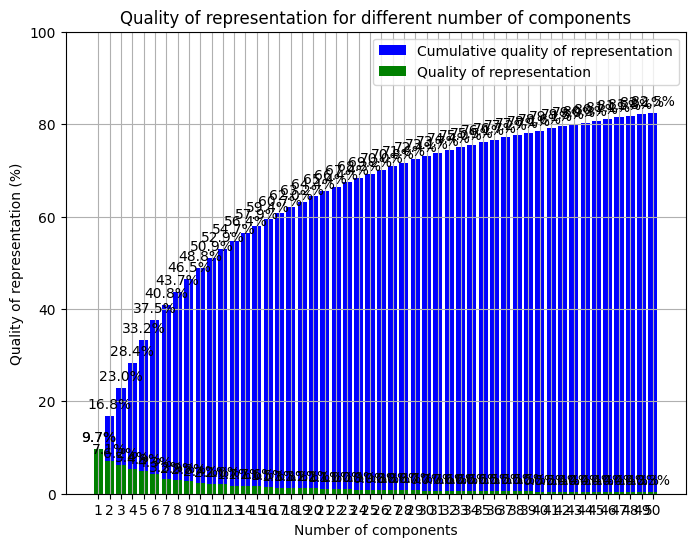

In [218]:
RD_N_COMPONENTS = 2
rd_principal_components, rd_explained_variance_ratio = custom_pca(x_train, n_compononents=RD_N_COMPONENTS)

# Projection des données sur les nouvelles dimensions
rd_projected_data = np.dot(x_train, rd_principal_components)

# Afficher le graphe des points de données après PCA
plot_pca_in_2d(rd_projected_data, y_train)

# Afficher la représentativité de chaque composante
RD_N_COMPONENTS_TO_SHOW = 50
cumulative_variance_ratio = np.cumsum(rd_explained_variance_ratio)
qualities = rd_explained_variance_ratio[:RD_N_COMPONENTS_TO_SHOW] * 100
cumulative_qualities = cumulative_variance_ratio[:RD_N_COMPONENTS_TO_SHOW] * 100

# Afficher la courbe de l'évolution de la qualité de représentation
plt.figure(figsize=(8, 6))
plt.bar(range(1, RD_N_COMPONENTS_TO_SHOW + 1), cumulative_qualities, color='b', label="Cumulative quality of representation")
plt.bar(range(1, RD_N_COMPONENTS_TO_SHOW + 1), qualities, color='g', label="Quality of representation")
plt.xlabel("Number of components")
plt.ylabel("Quality of representation (%)")
plt.ylim((0, 100))
plt.xticks(range(1, RD_N_COMPONENTS_TO_SHOW + 1))
for i, quality, cumulative_quality in zip(range(RD_N_COMPONENTS_TO_SHOW), qualities, cumulative_qualities):
    plt.text(i + 1, quality + 1, f"{quality:.1f}%", ha='center', va='bottom')
    plt.text(i + 1, cumulative_quality + 1, f"{cumulative_quality:.1f}%", ha='center', va='bottom')
plt.title("Quality of representation for different number of components")
plt.grid(True)
plt.legend()
plt.show()

# PCA - Compression-Decompression

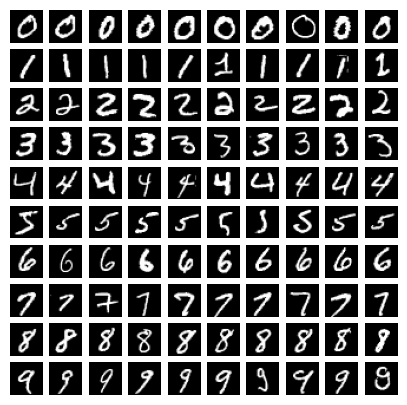

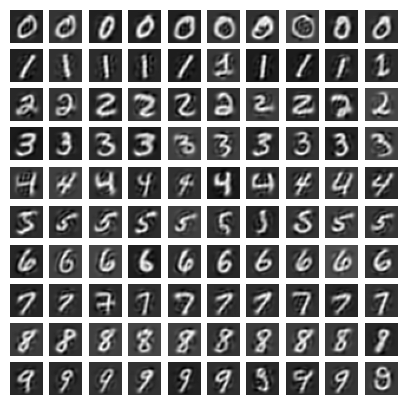

In [219]:
CD_N_COMPONENTS = 50

# Afficher les données avant compression
plot_digits_with_Y(X_train, Y_train)

# Compression des données sur CD_N_COMPONENTS dimensions
cd_principal_components, cd_explained_variance_ratio = custom_pca(x_train, n_compononents=CD_N_COMPONENTS)
cd_compressed_data = np.dot(x_train, cd_principal_components)

# Decompression des données
# Multiplier les données projetées dans l'espace de dimension réduite
# par les composantes principales transposées pour obtenir une approximation
# de la version décompressée des données
cd_decompressed_data = np.dot(cd_compressed_data, np.transpose(cd_principal_components))

# Afficher les données Après compression-decompression
plot_digits_with_Y(cd_decompressed_data.reshape((-1, 28, 28)), Y_train)

# PCA - Generation


LIMIT OF DIM 0 :  {'min': -3120.1228997493363, 'max': 324.8608543724316}
LIMIT OF DIM 1 :  {'min': -1399.6208823577913, 'max': 1448.6629205015208}


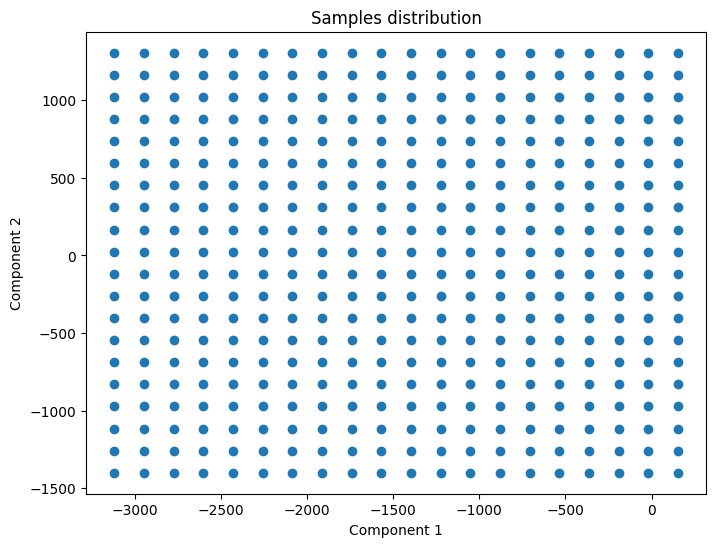

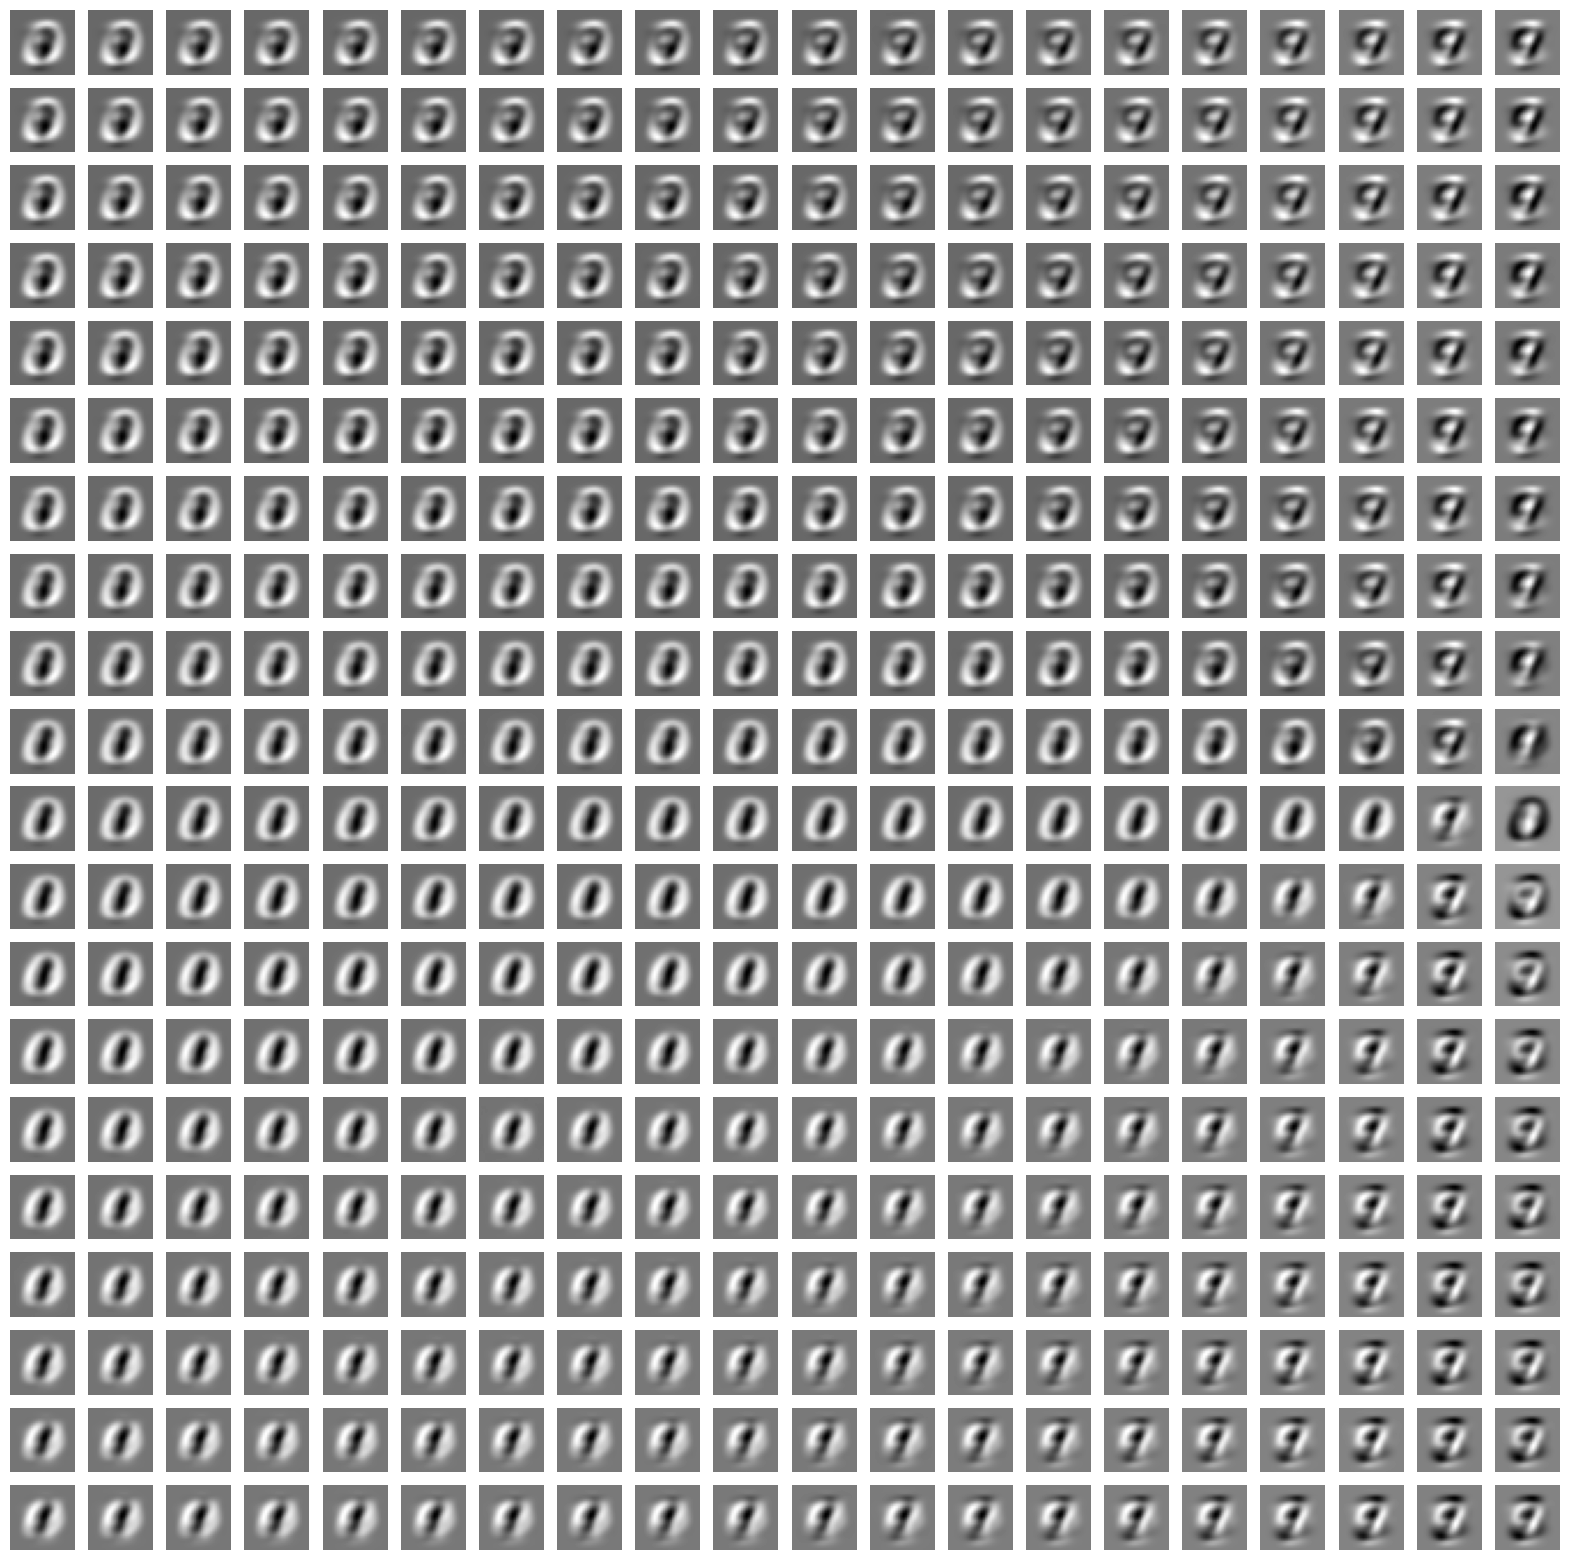

In [220]:
GEN_N_COMPONENTS = 2

# ACP
gen_principal_components, gen_explained_variance_ratio = custom_pca(x_train, n_compononents=GEN_N_COMPONENTS)
gen_projected_data = np.dot(x_train, gen_principal_components)

# Calculer les limites de chaque composante principale
limits = []
for dim in range(GEN_N_COMPONENTS):
    limit = {
        'min': gen_projected_data[:, dim].min(),
        'max': gen_projected_data[:, dim].max()
    }
    print(f"LIMIT OF DIM {dim} : ", limit)
    limits.append(limit)

n_samples = 400 # Must be a square

####################################################
# Fonctionne uniquement avec 2 dim
# Selectionner un nombre de données à générer
sqrt_n_samples = int(sqrt(n_samples))
samples = []
for j in range(sqrt_n_samples):
    y = limits[1]['min'] + (limits[1]['max'] - limits[1]['min']) * j / sqrt_n_samples
    for i in range(sqrt_n_samples):
        x = limits[0]['min'] + (limits[0]['max'] - limits[0]['min']) * i / sqrt_n_samples
        sample = np.array([x, y])
        samples.append(sample)
samples = np.array(samples)

plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Samples distribution")
plt.show()
####################################################
# Alternative : Fonctionne avec 2 ou plus dim
# # Selectionner un nombre de données à générer
# samples = []
# for i in range(n_samples):
#     sample = []
#     for dim in range(GEN_N_COMPONENTS):
#         dim_sample = np.random.uniform(limits[dim]['min'], limits[dim]['max'])
#         sample.append(dim_sample)
#     sample = np.array(sample)
#     samples.append(sample)
# samples = np.array(samples)
####################################################

# Générer les données dans l'espace des composantes principales
gen_generated_data = np.dot(samples, gen_principal_components.T)

# Dis - standardiser les données générées
gen_distandardized_data = (gen_generated_data * np.std(x_train)) + np.mean(x_train)

# Afficher les données Après compression-decompression
plot_digits(gen_distandardized_data.reshape((-1, 28, 28)), n_samples)